In [1]:
import numpy as np
import pandas as pd
import datetime
import pyfolio as pf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib
import seaborn as sns
import pytz
# https://github.com/quantopian/research_public/blob/master/advanced_sample_analyses/TSMOM/TS%20MOM.ipynb# https://github.com/quantopian/research_public/blob/master/advanced_sample_analyses/TSMOM/TS%20MOM.ipynb
# https://www.quantconnect.com/tutorials/strategy-library/improved-momentum-strategy-on-commodities-futures

D:\Anaconda\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# parameters from paper
tolerance = 0
look_back = 12

# vol scaling
vol_flag = 1
if vol_flag == 1:
    target_vol = 0.4
else:
    target_vol = 'no target_vol'

In [3]:
res = pd.read_csv("./data/futures.csv")
res['Date'] = pd.to_datetime(res['Date'], format='%Y-%m-%d')
res.set_index('Date', inplace=True)

In [4]:
res

,SM,NO,CL,UB,SB,TP,CD,CN,GC,TY,...,CC,S,SE,NV,HO,GX,JY,FV,JB,LC
Date,,,,,,,,,,,,,,,,,,,,,
1984-01-03,-0.046867,NaN,-0.007299,NaN,-0.038255,NaN,NaN,NaN,-0.016488,-0.002853,...,-0.017268,-0.036257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.013526
1984-01-04,-0.011366,NaN,0.003614,NaN,0.002395,NaN,NaN,NaN,-0.005494,0.004430,...,-0.036874,-0.013712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002736
1984-01-05,0.013230,NaN,-0.007318,NaN,-0.011783,NaN,NaN,NaN,-0.005520,-0.000253,...,0.019696,0.017140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022081
1984-01-06,-0.029521,NaN,-0.004134,NaN,-0.005356,NaN,NaN,NaN,-0.020646,0.002338,...,-0.043456,-0.031650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.010451
1984-01-09,-0.022181,NaN,0.009487,NaN,-0.024679,NaN,NaN,NaN,-0.006463,-0.001287,...,-0.034017,-0.015249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-25,NaN,NaN,NaN,NaN,NaN,-0.003929,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001076,NaN
2009-12-28,0.029884,0.004265,0.009212,-0.006131,0.006845,0.003942,0.006407,NaN,0.002804,-0.001786,...,-0.012530,0.029572,0.012179,0.002720,0.018602,0.008810,0.000547,-0.001717,-0.002614,0.007365
2009-12-29,0.014507,-0.001270,0.001255,0.001161,-0.018002,0.004908,-0.000317,-0.001917,-0.008850,0.001298,...,0.001950,0.008662,0.000367,0.015432,0.014144,-0.000252,-0.003761,0.000623,0.001076,-0.002927


In [5]:
std_index = res.resample('BM').last().index
mth_index = pd.DataFrame(index=std_index)
mth_index_vol = pd.DataFrame(index=std_index)
summary_stats = pd.DataFrame(index=['Asset', 'Start', 'Mean', 'Std', \
                                    'Skew', 'Kurt', 'Sharpe Ratio'])

In [6]:
# compute summary statistics for each future 
for col in res.columns:
    returns = res[col]
    returns.dropna(inplace=True)
    
    first_date = returns.index[0].strftime("%Y-%m-%d")
    ret_index = (1 + returns).cumprod()
    ret_index[0] = 1
    
    # equation (1) ex ante vol estimate
    day_vol = returns.ewm(ignore_na=False,
                          adjust=True,
                          com=60,   
                          min_periods=0).std(bias=False)
    vol = day_vol * np.sqrt(261) # 261 to annualize
    
    ret_index = pd.concat([ret_index, vol], axis=1)
    ret_index.columns = [col, 'vol']
    
    # convert to monthly
    ret_m_index = ret_index.resample('BM').last().ffill()
    ret_m_index.iloc[0][col] = 1

    mth_index = pd.concat([mth_index, ret_m_index[col]], axis=1)
    tmp = ret_m_index['vol']
    tmp.name = col + "_Vol"
    mth_index_vol = pd.concat([mth_index_vol, tmp], axis=1)

    tmp_mean = ret_index[col].pct_change().mean()*252
    tmp_std = ret_index[col].pct_change().std()*np.sqrt(252)
    tmp_skew = ret_index[col].pct_change().skew()
    tmp_kurt = ret_index[col].pct_change().kurt()
    sr = tmp_mean / tmp_std

    result_dict = {'Asset': col,
            'Start': first_date,
            'Mean': np.round(tmp_mean,4),
            'Std':  np.round(tmp_std,4),
            'Skew': np.round(tmp_skew,4),
            'Kurt': np.round(tmp_kurt,4),
            'Sharpe Ratio': np.round(sr,4),
            }
    summary_stats[col] = pd.Series(result_dict)

In [7]:
summary_stats

,SM,NO,CL,UB,SB,TP,CD,CN,GC,TY,...,CC,S,SE,NV,HO,GX,JY,FV,JB,LC
Asset,SM,NO,CL,UB,SB,TP,CD,CN,GC,TY,...,CC,S,SE,NV,HO,GX,JY,FV,JB,LC
Start,1984-01-03,2002-05-20,1984-01-03,1998-10-06,1984-01-03,1990-05-21,1986-04-07,1989-09-19,1984-01-03,1984-01-03,...,1984-01-03,1984-01-03,2002-05-20,1997-05-09,1986-07-02,1990-11-27,1986-05-28,1988-05-24,1985-10-22,1984-01-03
Mean,0.0533,0.0472,0.1346,0.0038,0.0181,-0.0553,-0.0082,0.0098,-0.0255,0.0156,...,-0.039,-0.0084,0.0367,0.0167,0.1641,0.0389,-0.0301,0.0012,0.0074,0.0026
Std,0.2439,0.1346,0.3759,0.0997,0.3685,0.2428,0.0724,0.064,0.1615,0.0689,...,0.3035,0.2277,0.1348,0.1391,0.3659,0.237,0.1143,0.0431,0.0542,0.1446
Skew,-0.031,-0.1743,-0.3765,-0.1955,-0.0212,0.2691,0.0903,-0.2109,0.1759,0.076,...,0.1705,-0.1572,0.3729,-0.2998,-0.3195,0.0231,0.6129,-0.0979,-0.5901,-0.0978
Kurt,2.5715,2.9403,10.9173,2.0124,4.0372,9.5202,8.6474,2.3455,7.768,3.2148,...,2.5969,2.628,5.9377,3.8182,9.5853,6.0168,6.7518,2.7085,8.9518,1.3376
Sharpe Ratio,0.2186,0.3508,0.358,0.0382,0.0492,-0.2279,-0.1137,0.1538,-0.1577,0.2269,...,-0.1285,-0.0368,0.2724,0.12,0.4483,0.1642,-0.2636,0.0284,0.136,0.0178


In [8]:
summary_stats = summary_stats.transpose()
futures_list = pd.read_csv("./data/futures_list.csv")
merged = summary_stats.reset_index().merge(futures_list)
merged.sort_values(by=["ASSET_CLASS", "FUTURES"], inplace=True)
del merged['Asset'], merged['index']

In [9]:
merged.set_index(['ASSET_CLASS', 'FUTURES']).style.set_properties(**{'text-align': 'right'})

In [10]:
pnl = pd.DataFrame(index=std_index)
leverage = pd.DataFrame(index=std_index)
strategy_cumm_rtns = pd.DataFrame(index=std_index)

In [11]:
for col in mth_index:
    df = pd.concat([mth_index[col], mth_index_vol[col+"_Vol"]], axis=1)
    df['returns'] = df[col].pct_change(look_back)
    
    df['pnl'] = 0.
    df['leverage'] = 0.

    for k, v in enumerate(df['returns']):
        if k <= look_back:
            # skip the first 12 observations
            continue
        if df['returns'].iloc[k-1] < tolerance:
            # negative returns, sell and hold for 1 mth, then close position
            if vol_flag == 1:
                df['pnl'].iloc[k] = (df[col].iloc[k - 1] / df[col].iloc[k] - 1) * \
                                    target_vol / df[col+"_Vol"].iloc[k - 1]
                df['leverage'].iloc[k] = target_vol / df[col+"_Vol"].iloc[k - 1]
            else:
                df['pnl'].iloc[k] = (df[col].iloc[k - 1] / df[col].iloc[k] - 1)                   
                df['leverage'].iloc[k] = 1.
        elif df['returns'].iloc[k-1] > tolerance:
            # positive returns, buy and hold for 1 mth, then close position
            if vol_flag == 1:
                df['pnl'].iloc[k] = (df[col].iloc[k] / df[col].iloc[k - 1] - 1) * \
                                    target_vol / df[col+"_Vol"].iloc[k - 1]
                df['leverage'].iloc[k] = target_vol / df[col+"_Vol"].iloc[k - 1]
            else:
                df['pnl'].iloc[k] = (df[col].iloc[k] / df[col].iloc[k - 1] - 1) 
                df['leverage'].iloc[k] = 1.

    # convert to cummulative index
    pnl = pd.concat([pnl, df['pnl']], axis=1)
    leverage = pd.concat([leverage, df['leverage']], axis=1)
    
    ret_index = (1 + df['pnl'][13:]).cumprod()
    ret_index[0] = 1
    strategy_cumm_rtns = pd.concat([strategy_cumm_rtns, ret_index], axis=1)

In [12]:
pnl.columns = res.columns
leverage.columns = leverage.columns
strategy_cumm_rtns.columns = res.columns
df = pnl
df['port_avg'] = df.mean(skipna = 1, axis=1)
Strategy = df['port_avg'].copy()
Strategy.name = "TSMOM with Vol"
dataport_index = (1 + df['port_avg']).cumprod()

In [13]:
print ("Annualized Sharpe Ratio = ", pf.ep.sharpe_ratio(df['port_avg'], period='monthly'))
print("Annualized Mean Returns = ", pf.ep.annual_return(df['port_avg'], period='monthly'))
print("Annualized Standard Deviations = ", pf.ep.annual_volatility(df['port_avg'], period='monthly'))
print ("Max Drawdown = ", pf.ep.max_drawdown(df['port_avg']))
print ("Calmar ratio = ", pf.ep.calmar_ratio(df['port_avg'], period='monthly'))

Annualized Sharpe Ratio =  1.5594286210223933
Annualized Mean Returns =  0.15820525315443468
Annualized Standard Deviations =  0.09777485565969159
Max Drawdown =  -0.14072620290687676
Calmar ratio =  1.1242060816429786


Start date,1984-01-30
End date,2009-12-30
Total months,14
,Backtest
Annual return,2085.225%
Cumulative returns,4454.323%
Annual volatility,44.806%
Sharpe ratio,7.15
Calmar ratio,148.18
Stability,0.96
Max drawdown,-14.073%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,14.07,2003-05-29,2003-08-28,2003-12-30,153
1,13.54,2009-02-26,2009-07-30,NaT,NaN
2,9.17,2008-06-29,2008-09-29,2008-10-30,89
3,9.13,1995-03-30,1995-08-30,1996-04-29,283
4,8.03,1993-12-30,1994-03-30,1994-10-30,217


D:\Anaconda\lib\site-packages\pyfolio\tears.py:906: UserWarning: Passed returns do not overlap with anyinteresting times.
  warnings.warn('Passed returns do not overlap with any'


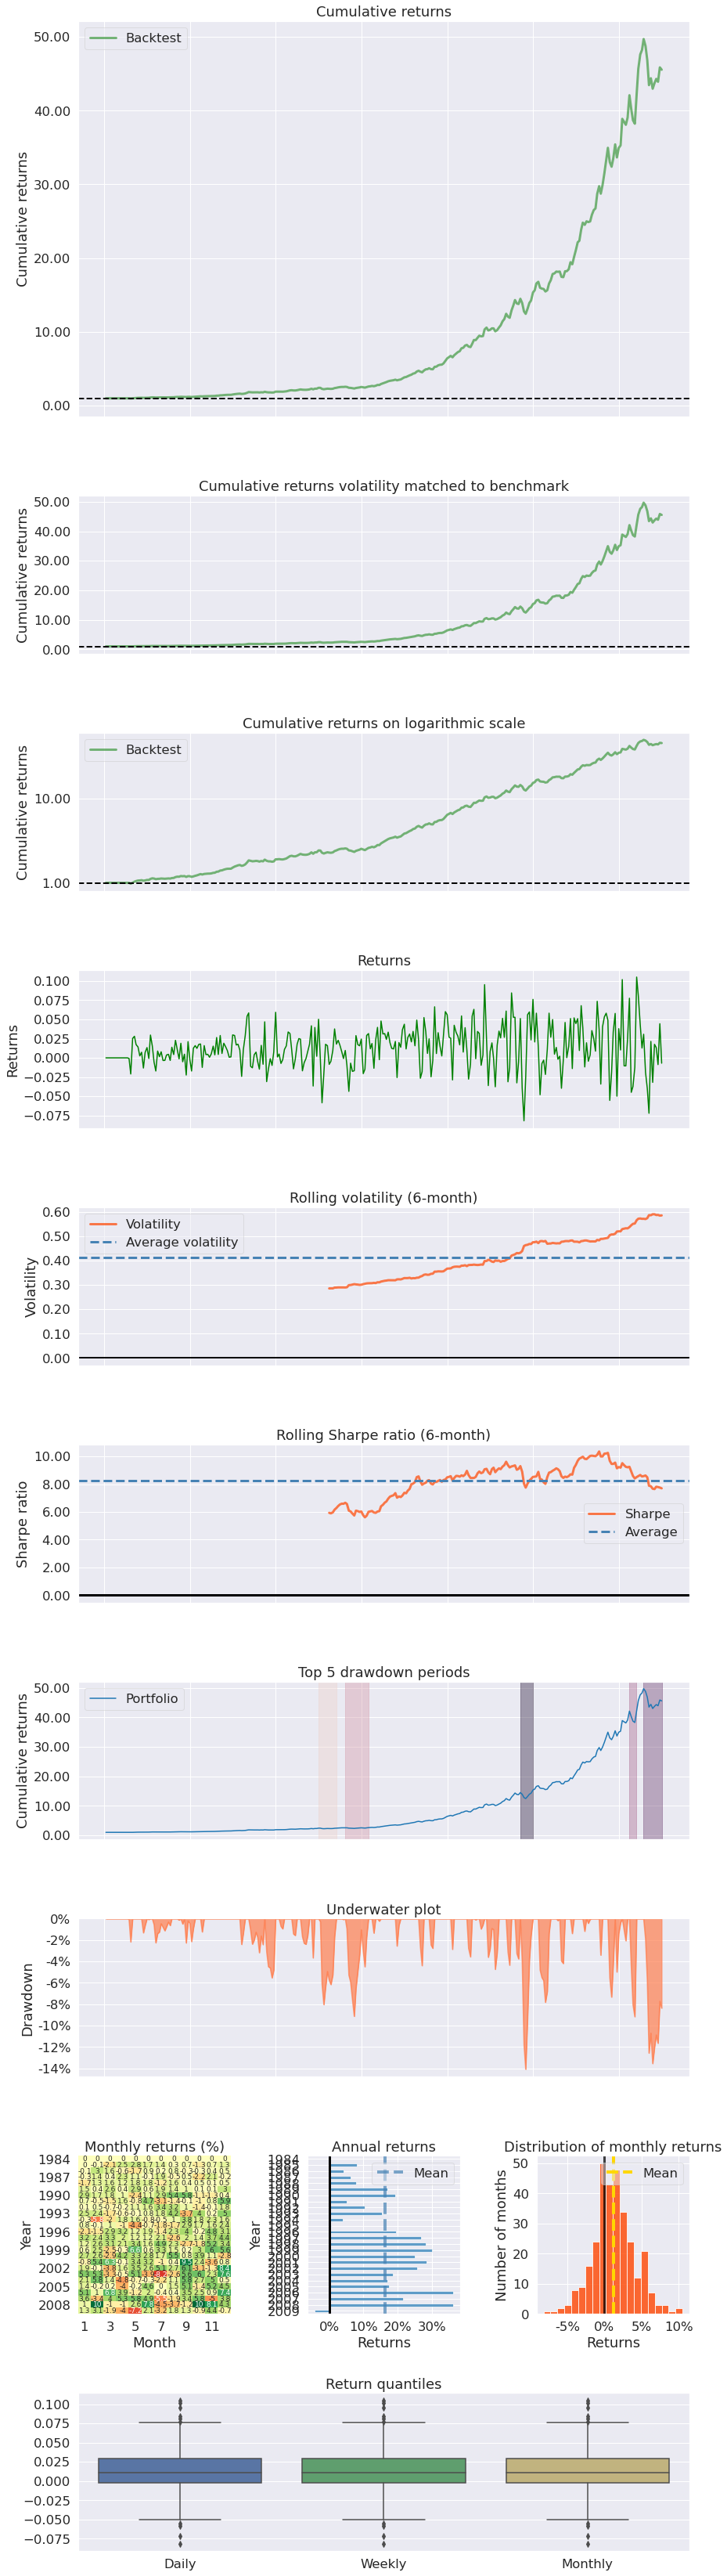

In [14]:
eastern = pytz.timezone('US/Eastern')
df['port_avg'].index = df['port_avg'].index.tz_localize(pytz.utc).tz_convert(eastern)
pf.create_full_tear_sheet(df['port_avg'])

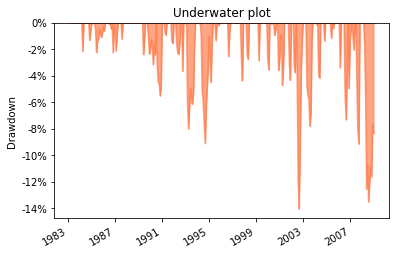

In [15]:
pf.plot_drawdown_underwater(df['port_avg']);

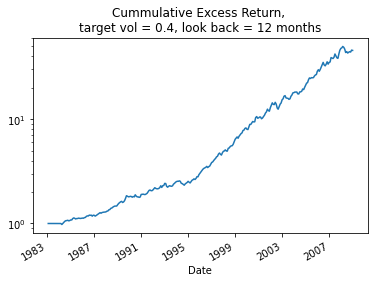

In [16]:
ax = (1 + df['port_avg']).cumprod().plot(logy=True);
ax.set_title("Cummulative Excess Return, " + \
            "\ntarget vol = " + str(target_vol) + ", look back = " + \
             str(look_back) + " months");

In [17]:
tmp = df['port_avg'].reset_index()
tmp['Date'] = pd.to_datetime(tmp['Date'], format='%Y-%m-%d')
tmp = tmp.set_index('Date')
tmp['month'] = tmp.index.month
tmp['year'] = tmp.index.year
tmp = np.round(tmp, 3)
res = tmp.pivot('year', 'month', 'port_avg')
res['total'] = np.sum(res, axis=1)

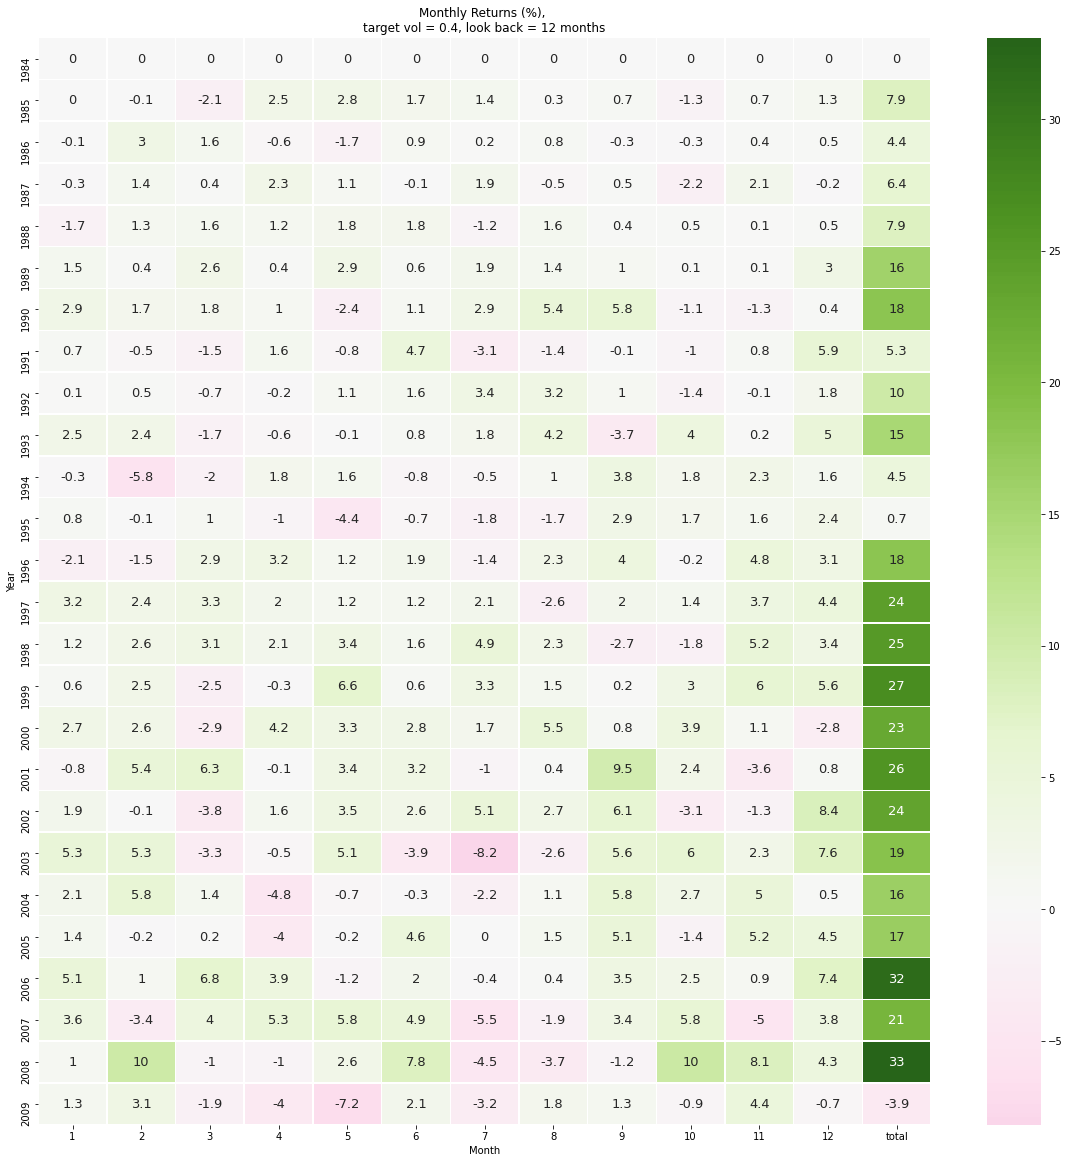

In [18]:
fig, ax = plt.subplots(figsize=(20,20));
sns.heatmap(res.fillna(0) * 100,
            annot=True,
            annot_kws={
                "size": 13},
            alpha=1.0,
            center=0.0,
            cbar=True,
            cmap=matplotlib.cm.PiYG,
            linewidths=.5,
            ax = ax); 
ax.set_ylabel('Year');
ax.set_xlabel('Month');
ax.set_title("Monthly Returns (%), " + \
            "\ntarget vol = " + str(target_vol) + ", look back = " + \
             str(look_back) + " months");
plt.show()

Risk Factor Analysis

In [19]:
TSMOM = Strategy.reset_index()[["Date", "TSMOM with Vol"]]
TSMOM = TSMOM.set_index("Date")
TSMOM = TSMOM.reset_index()

In [20]:
df = pd.read_csv("./data/factors.csv")
df["Date"] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
data = df.merge(TSMOM)
data = data[['Date', 'SMB', 'HML', 'Mom', 'bond_index', 'equity_index', \
             'commodity_index', 'TSMOM with Vol']].copy()
data.columns = ['Date', 'SMB', 'HML', 'MOM', 'BOND', 'EQUITY', 'COMMODITY', 'PORTFOLIO']
data = data.dropna()
data = data.set_index("Date")
data = data.reset_index()
X = data[['SMB', 'HML', 'MOM', 'BOND', 'EQUITY', 'COMMODITY']].copy()
X = sm.add_constant(X)
model = sm.OLS(data['PORTFOLIO'].astype(float), X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              PORTFOLIO   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     2.140
Date:                Mon, 15 Feb 2021   Prob (F-statistic):             0.0487
Time:                        21:03:12   Log-Likelihood:                 677.30
No. Observations:                 312   AIC:                            -1341.
Df Residuals:                     305   BIC:                            -1314.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0120      0.002      6.797      0.0

Compare with SP500

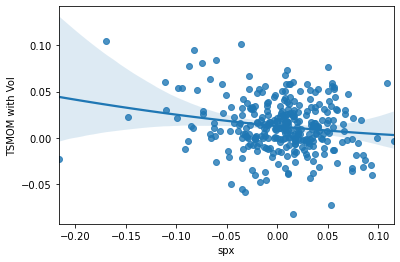

In [21]:
SPX = df[["Date", "spx"]].copy()
SPX["Date"] = pd.to_datetime(SPX['Date'], format='%Y-%m-%d')
TSMOM = Strategy.reset_index()[["Date", "TSMOM with Vol"]].dropna()
TSMOM = TSMOM.set_index("Date")
TSMOM = TSMOM.reset_index()
comb = TSMOM.merge(SPX)
sns.regplot(x="spx", y="TSMOM with Vol", data=comb, order=2);

In [22]:
X = comb['spx'].copy()
X = sm.add_constant(X)
model = sm.OLS(comb['TSMOM with Vol'].astype(float), X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         TSMOM with Vol   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     9.535
Date:                Mon, 15 Feb 2021   Prob (F-statistic):            0.00220
Time:                        21:03:12   Log-Likelihood:                 675.59
No. Observations:                 312   AIC:                            -1347.
Df Residuals:                     310   BIC:                            -1340.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0132      0.002      8.319      0.0

In [23]:
X = comb['spx'].copy()
X = X ** 2
Y = comb['TSMOM with Vol']
Y = Y ** 2
model = sm.OLS(Y, X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:         TSMOM with Vol   R-squared (uncentered):                   0.165
Model:                            OLS   Adj. R-squared (uncentered):              0.163
Method:                 Least Squares   F-statistic:                              61.66
Date:                Mon, 15 Feb 2021   Prob (F-statistic):                    6.67e-14
Time:                        21:03:12   Log-Likelihood:                          1553.1
No. Observations:                 312   AIC:                                     -3104.
Df Residuals:                     311   BIC:                                     -3101.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------